In [1]:
import numpy as np
import pandas as pd
from astropy.visualization import astropy_mpl_style
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
from astropy import visualization as av
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.time import Time, TimeDelta
from astroquery.jplhorizons import Horizons
from matplotlib import pyplot as plt
from photutils.aperture import CircularAperture, aperture_photometry

from tools import km_to_pixels


In [2]:
DF = pd.read_csv('ZPLog.csv')
GEOMETRY = np.load('geometry', allow_pickle=True)


class CometObs:
    def __init__(self, band, mmdd):
        self.band = band
        self.mmdd = mmdd
        self.flux = None
        self.zp = None
        self.zp_err = None

    def get_zeropoint(self):
        self.zp = DF[DF['MMDD'] == self.mmdd][DF['Filt'] == self.band]['ZPm']
        self.zp_err = DF[DF['MMDD'] == self.mmdd][DF['Filt'] == self.band]['ZPsigm']
        return float(self.zp), float(self.zp_err)

    def get_flux_from_comove(self, fits_image, comove_shift=[300, 300], sky_dim=50, ss_dim=200,
                             aperture='total', delta=None):
        """
        :param fits_image: the path to the fits image
        :param comove_shift: a correction needed due to the comoving (RA and DEC do not match the actual position of the
        object in the comoving image)
        :param sky_dim: the size in pixel for the sky snapshot from which is extracted the median sky value
        :param ss_dim: the comet snapshot size
        :param aperture: aperture radius, 'total' if total flux is needed
        :param delta: distance from the observer to the object
        :return: the flux of the comet, after subtracting the median sky value
        """
        # print(fits_image)
        hdul = fits.open(fits_image)
        hdr = hdul[0].header
        w = WCS(hdul[0].header)
        c = SkyCoord(f"{hdr['RA']} {hdr['DEC']}", frame='icrs', unit=(u.hourangle, u.deg))  # 2I initial position coords
        x, y = w.world_to_pixel(c)
        # sometimes, comoving image is cropped and x or y can have negative values,
        # so in order to avoid errors we set x or y to 0:
        if x < 0:
            x = 0
        if y < 0:
            y = 0
        # print(x, y)
        # print(np.max(hdul[0].data))

        # take a snapshot of the comet:
        if ss_dim > 0:
            shot = hdul[0].data[int(y):int(y) + ss_dim, int(x):int(x) + ss_dim]
        else:
            shot = hdul[0].data[int(y) + ss_dim:int(y), int(x) + ss_dim:int(x)]
        expanded_dim = 1000
        expanded = np.zeros([expanded_dim, expanded_dim], dtype=np.int32)
        expanded[int((expanded_dim - ss_dim)/2):int((expanded_dim + ss_dim)/2),int((expanded_dim - ss_dim)/2):int((expanded_dim + ss_dim)/2)] = shot
        shot = expanded
#         fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
#         ax1.imshow(shot)
#         ax2.imshow(hdul[0].data)
#         plt.show()

        # find the position of the maximum intensity pixel:
        args = np.unravel_index(np.argmax(shot), shot.shape)

        # get a sky area to compute sky median value:
        if ss_dim > 0:
            sky = shot[args[0] + comove_shift[1]: args[0] + comove_shift[1] + sky_dim,
                  args[1] + comove_shift[1]: args[1] + comove_shift[1] + sky_dim]
        else:
            sky = shot[args[0] - comove_shift[0] - sky_dim: args[0] - comove_shift[0],
                  args[1] - comove_shift[0] - sky_dim: args[1] - comove_shift[0]]
        # print('sky median = ', np.median(sky))
        # print('sky std = ', np.std(sky))

        # subtract sky median value from the comet image:
        shot = shot - np.median(sky)

        # extract comet profile:
        profile = shot[args[0] - comove_shift[0]: args[0] + comove_shift[1],
                       args[1] - comove_shift[0]: args[1] + comove_shift[1]]

#         fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
#         ax1.imshow(profile)
#         ax1.plot(comove_shift[0], len(profile) - comove_shift[1], 'ro')
#         ax2.imshow(sky)
#         plt.show()

        if aperture == 'total':
            self.flux = np.sum(profile)
        elif delta is not None:
            aperture_pixels = km_to_pixels(aperture, delta)
            aperture = CircularAperture([comove_shift[0], len(profile) - comove_shift[1]], aperture_pixels)
            self.flux = round(float(aperture_photometry(profile, aperture, method='subpixel')["aperture_sum"]), 4)

        return self.flux

1002


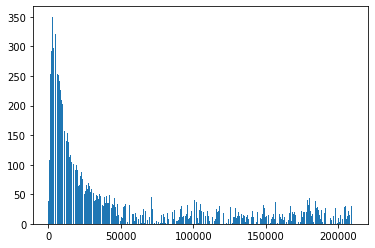

1003


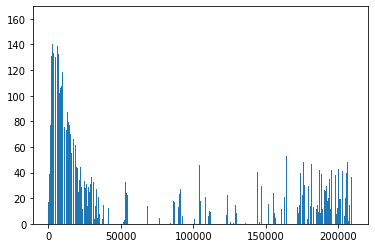

1004


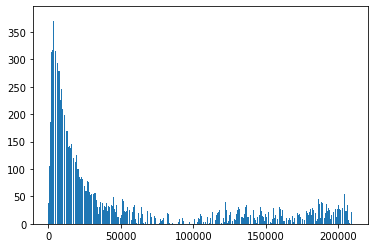

1006


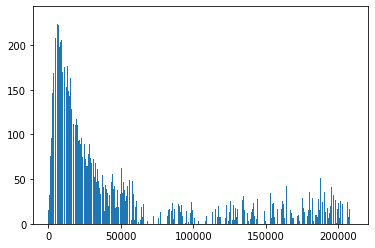

1011


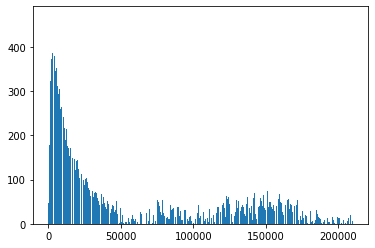

1012


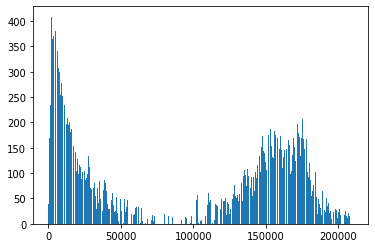

1014


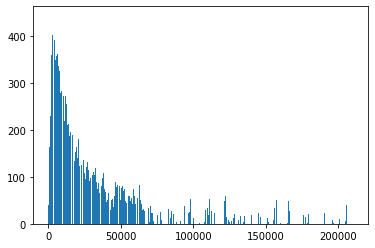

1018


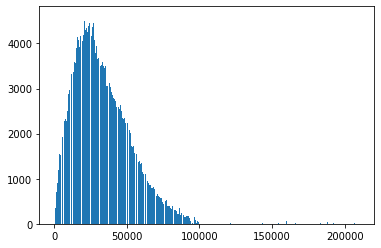

1019


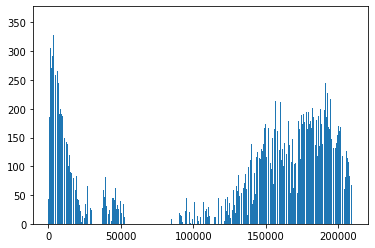

In [4]:
obs_dict = DF[['MMDD', 'Filt', 'JDm', 'ZPm', 'ZPsigm']]
delta = []
for obs in list(obs_dict.iterrows())[:40]:
    obs = obs[1]
    if obs["Filt"] != 'r':
        continue
    fits_path = f'out/{obs["MMDD"]}_{obs["Filt"]}/out_med/Med{obs["MMDD"]}comove.fits'
    obs_obj = CometObs(band=obs["Filt"], mmdd=obs["MMDD"])
    print(obs["MMDD"])
    comove_shift = [20, 50]
    ss_dim = 200
    # correction for some special cases:
    if obs["MMDD"] == 1212:
        comove_shift = [10, 60]
    if obs["MMDD"] == 1209 and obs["Filt"] == 'r':
        comove_shift = [10, 60]
    if obs["MMDD"] == 1018:
        ss_dim = -225
        comove_shift = [30, 40]

    # ephemerides
    tstart = Time(obs['JDm'], format='jd')
    tend = tstart + TimeDelta('60', format='sec')

    # https://astroquery.readthedocs.io/en/latest/api/astroquery.jplhorizons.HorizonsClass.html#astroquery
    jpl_ephem = Horizons(id='2I', location='954',
                        id_type="smallbody",
                        epochs={"start": str(tstart.iso),
                                "stop": str(tend.iso),
                                "step": "1m"}
                        ).ephemerides().to_pandas()
    delta.append(str('{:.7f}'.format(jpl_ephem['delta'][0])))
    
    edges = list(range(100, 210000, 200))
    width = 0.85*(edges[1] - edges[0])
    left_edges = edges[:-1]
    flux_arr = [obs_obj.get_flux_from_comove(fits_path, ss_dim=300, aperture=ap, delta = float(delta[-1])) for ap in edges]
    heights = np.array([flux_arr[j+1] - flux_arr[j] for j in range(len(flux_arr)-1)])
    heights[heights<0]=0
    plt.bar(left_edges, heights, align='edge', width=width)
    plt.show()
    f = open(f"{obs['MMDD']}_{obs['Filt']}_hist", 'w')
    for j in range(len(left_edges)):
        f.write(f"{left_edges[j]} {heights[j]}\n")
    f.close()

#fits_image = FitsImage(f'./out/{date}/{band}_comoving.fits')
#plt.style.use(astropy_mpl_style)
# image_file = get_pkg_data_filename(path)
# fits.info(image_file)
